## Creating features

In this notebook, we go through the process of creating features to put into our machine learning model. The goal of this is to create time series of features that we think are good to enter into an LSTM model. At the end, we will try to put this into tensorflow dataset format using this [tutorial](https://www.tensorflow.org/datasets/add_dataset). 


In [145]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# Importing ta library from pandas for technical analysis functions
import pandas_ta as ta

In [146]:
data = pd.read_parquet('btc_usd_1h.parquet')

In [147]:
data.head()

,timestamp,open,high,low,close,volume,trade_count,vwap
0,2021-01-01 06:00:00+00:00,29255.71,29338.25,29153.55,29234.15,42.244289,1243.0,29237.240312
1,2021-01-01 07:00:00+00:00,29235.61,29236.95,28905.00,29162.50,34.506038,1070.0,29078.423185
2,2021-01-01 08:00:00+00:00,29162.50,29248.52,28948.86,29076.77,27.596804,1110.0,29091.465155
3,2021-01-01 09:00:00+00:00,29075.31,29372.32,29058.05,29284.92,20.694200,880.0,29248.730924
4,2021-01-01 10:00:00+00:00,29291.54,29400.00,29232.16,29286.63,16.617646,742.0,29338.609132


The goal of this is to create features which might be useful in predicting the one step ahead closing price of BTC/USD. For now, we will only use information gained from the historical prices here. Not dealing with external pricing informatino. We will brainstorm a bit around this. Let's start with technical indicators that may be useful: 

* **RSI** -> relative strength index over a couple of lookback periods. 
    * This indicator is sort of a tried and true metric for getting a sense of if there will be reversals in the market. Of course, this needs to be used in conjunction with features but should be a good start
* **MACD** -> moving average convergence and divergence. Another very common indicator which traders use. We can explore this a bit. Some more reading on the MACD [here](https://www.investopedia.com/terms/m/macd.asp#:~:text=Moving%20average%20convergence%2Fdivergence%20(MACD%2C%20or%20MAC%2DD,EMAs)%20of%20a%20security's%20price.)
* **Bollinger Bands**
    * We can use the %B column which gives us how close or far away the price is to the upper band
* **Simple moving averages** -> these smooth out the price so that you can focus on trends that are happening
    * Where is the price relative to the simple moving average? -> as percentage of moving average, as z-score away from moving average
    * Relationship of moving averages to each other -> relative difference between longer and shorter moving averages? 
* **Exponential moving averages** -> these moving averages move a little quicker than the simple moving average and can give us a sense of short term price action
    * How far is price from this moving average (normalized)
    * How far is this moving average from a simple moving average potentially? 

I think that's enough of the technical features for now. What are some other features that we can try out? 
* Lagged returns over some period of time --> if you see the sequence of returns, then you can maybe get a guess around what the future momentum might be
* Rolling volatility -> what has been the average squared return? Giving a sense of magnitude that's there
* Open - Close
* High - Low

We will go through each of these features, take a look at them, and understand their properties. Should have a separate technical analysis folder where we write down the different technical features, plot them, and say other things about them. 

### RSI

This is the relative strength index. The formula for it can be found [here](https://www.investopedia.com/terms/r/rsi.asp). 

In [148]:
rsi = ta.rsi(close = data['close'], length = 14)

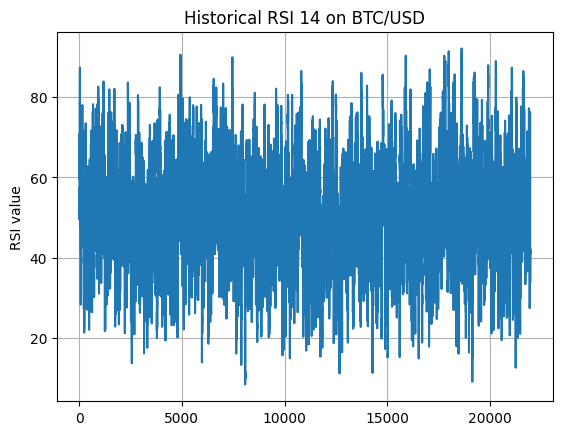

In [149]:
rsi.dropna().plot()
plt.title("Historical RSI 14 on BTC/USD")
plt.ylabel('RSI value')
plt.grid(True) 
plt.show()

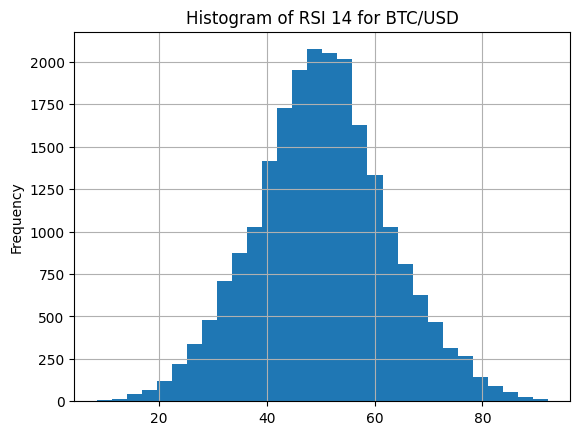

In [150]:
rsi.plot(kind = 'hist', bins = 30)
plt.title("Histogram of RSI 14 for BTC/USD")
plt.grid()
plt.show()

We can see here a couple of things about RSI: 
* It is very mean reverting. It rarely comes above 80 and below 20. 
    * This is by design since the indicator stays between 0 and 100
* The distribution is very gaussian which is nice


### MACD

MACD stands for **M**oving **A**verage **C**onvergence **D**ivergence and is a very popular indicator that traditional technical traders use. To calculate the MACD, we do the following: 
* Calculate the 26 period EMA of the price series 
* Calculate the 12 period EMA of the price series 
* Calculate the MACD line which is the 12 period EMA - 26 period EMA 
* Calculate a signal line which is the 9-period EMA of the MACD line

In pandas-ta, we get three columns returned to us: 
* First column is the MACD value itself
* Second column is what they call the Histogram which is the difference between the MACD and the signal line
* Third column is the signal line which is the exponential moving average of the MACD line

In [151]:
macd = ta.macd(close = data['close'])
macd.columns = ['MACD', 'Histogram', 'Signal']

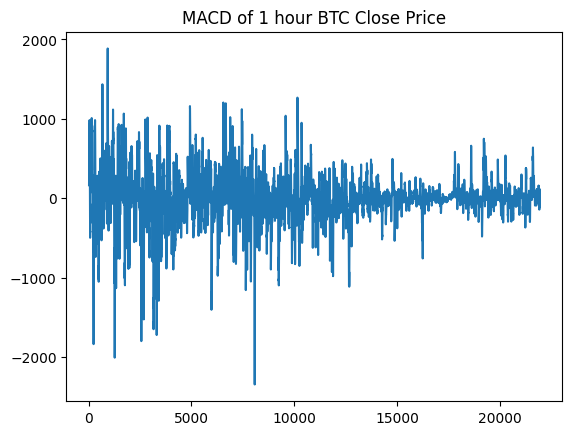

In [152]:
macd['MACD'].plot()
plt.title("MACD of 1 hour BTC Close Price")
plt.show()

A couple of observations here: 
* The MACD line has varying variability depending on the time period
    * This comes from the MACD being based on actual price values rather than some sort of normalized value 
* In the past, the MACD value was more variable than in later periods

Some conclusions: 
* We need to normalize this data in some way that makes sense. A 100 point move in MACD now is not nearly the same as a 100 point move in the past
    * 

### Bollinger Bands

In [153]:
bbands = ta.bbands(close = data['close'], length = 50)

In [154]:
cols = ['lower_band', 'middle_band', 'upper_band', 'bandwidth', '%B']
bbands.columns = cols

# Adding in some columns for side by side visualization
bbands['timestamp'] = data['timestamp']
bbands['close'] = data['close']

<Axes: >

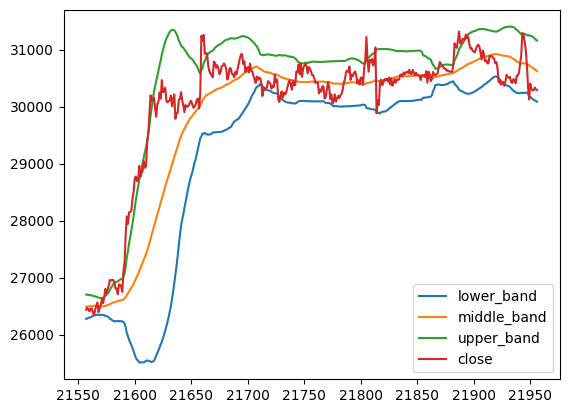

In [155]:
bbands[['lower_band', 'middle_band', 'upper_band', 'close']].iloc[-400:].plot()

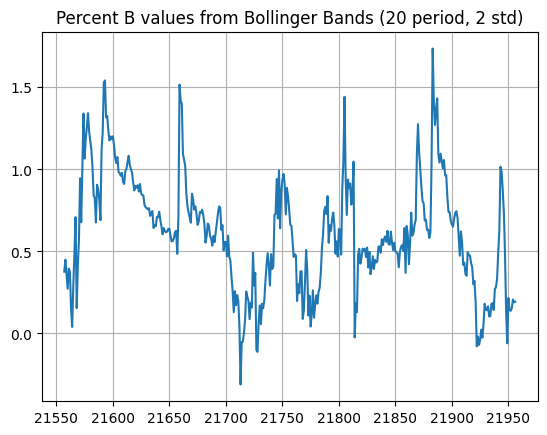

In [156]:
tail_values = 400
bbands.iloc[-tail_values:]['%B'].plot()
plt.title("Percent B values from Bollinger Bands (20 period, 2 std)")
plt.grid()
plt.show()

* The %B values look like good features to keep since they are normalized in some way. The formula for it is $100 * \frac{P - L}{U - L}$. Where U and L are the upper and lower bands. 
    * A value above 1 means that you are above the upper bands
    * A value below 0 means that you are below the lower bands
    * A value in the middle means you are in between each of them
    

### Simple moving averages

Simple moving averages are the most common technical indicator used. They are just a rolling average of the values of some series and help with smoothing out the data in some way. 

The features we will create around this are: 
* Log of the close price - log of the SMA of the close price
* Log of one SMA minus the log of another SMA with a different window

For now, we will use the 12 hour SMA, 24 hour SMA, and the 72 hour SMA. 

In [157]:
short_sma_period = 12
medium_sma_period = 24
long_sma_period = 72

short_sma = data['close'].rolling(short_sma_period).mean() 
medium_sma = data['close'].rolling(medium_sma_period).mean() 
long_sma = data['close'].rolling(long_sma_period).mean()

short_sma.name = f'SMA_{short_sma_period}'
medium_sma.name = f'SMA_{medium_sma_period}'
long_sma.name = f'SMA_{long_sma_period}'

log_short_sma = short_sma.apply(np.log)
log_medium_sma = medium_sma.apply(np.log)
log_long_sma = long_sma.apply(np.log)
log_close = data['close'].apply(np.log)

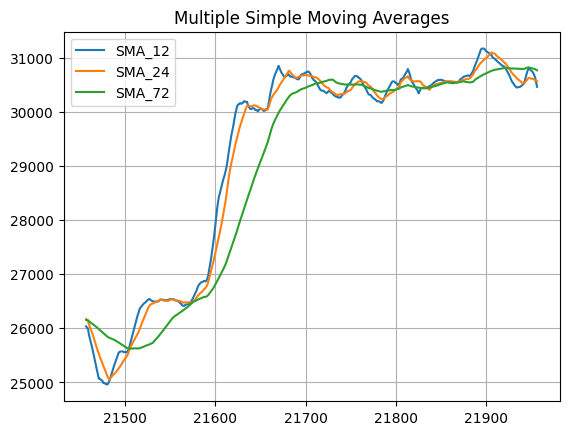

In [158]:
smas = pd.concat([short_sma, medium_sma, long_sma], axis = 1)
smas.iloc[-500:].plot()
plt.title("Multiple Simple Moving Averages")
plt.grid()
plt.show()

In [198]:
# We are going to create some features here of course
log_close_to_short_sma = log_close - log_short_sma
log_close_to_medium_sma = log_close - log_medium_sma
log_close_to_long_sma = log_close - log_long_sma

log_close_to_short_sma.name = 'log_close_to_short_sma'
log_close_to_medium_sma.name = 'log_close_to_medium_sma'
log_close_to_long_sma.name = 'log_close_to_long_sma'

### Exponential Moving Averages

Exponential moving averages are a way for us to get a moving average which is more responsive to recent datapoints. The features we will create from this are: 
* Log of the EMA to the moving averages created before
* Log of the 26 period EMA to the 12 period EMA ---> sort of a log MACD in a way but not entirely


In [160]:
fast_ema_period = 12
slow_ema_period = 26

ema_26 = data['close'].ewm(halflife = slow_ema_period).mean()
ema_12 = data['close'].ewm(halflife = fast_ema_period).mean()

ema_26.name = f'EMA_{slow_ema_period}'
ema_12.name = f'EMA_{fast_ema_period}'

In [161]:
emas = pd.concat([ema_12, ema_26], axis = 1)
mas = pd.concat([emas, smas], axis = 1)

In [162]:
log_fast_ema = ema_12.apply(np.log)
log_slow_ema = ema_26.apply(np.log)

log_macd = log_fast_ema - log_slow_ema
log_macd.name = 'LogMacd'

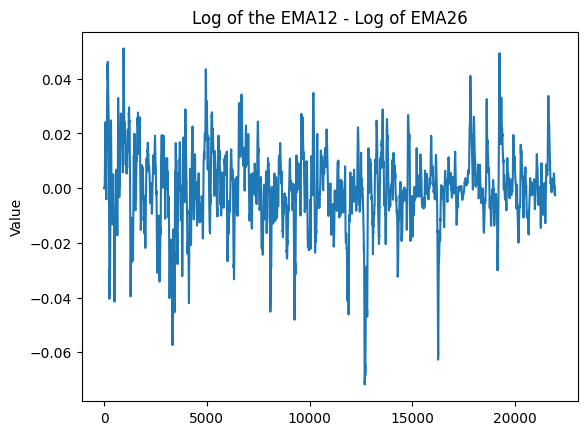

In [163]:
log_macd.plot()
plt.title("Log of the EMA12 - Log of EMA26")
plt.ylabel("Value")
plt.show()

<Axes: ylabel='Frequency'>

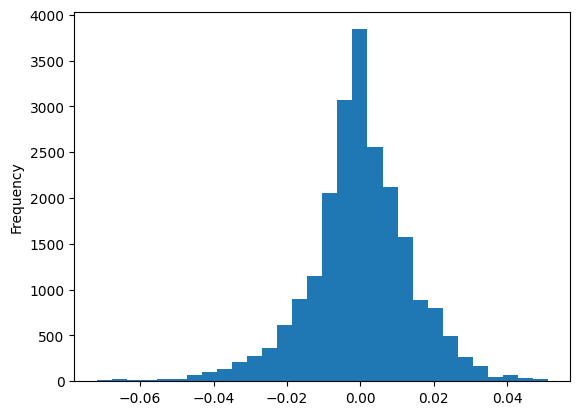

In [164]:
log_macd.plot(kind = 'hist', bins = 30)

In [165]:
log_macd.describe()

count    21957.000000
mean        -0.000276
std          0.014193
min         -0.071747
25%         -0.007165
50%         -0.000184
75%          0.007880
max          0.051031
Name: LogMacd, dtype: float64

In [166]:
# Creating all the differences in the fast EMA with the SMA values
log_fast_ema_slow_sma = log_fast_ema - log_long_sma
log_fast_ema_med_sma = log_fast_ema - log_medium_sma
log_fast_ema_fast_sma = log_fast_ema - log_short_sma

### Lagged returns

We of course would like to have the previous returns into this analysis. These give us a sense of the past momentum that was happening in the time series. 

In [167]:
num_lags = 10
close_to_close_returns = data['close'].pct_change()

lagged_returns_df = pd.DataFrame() 

for i in range(1, num_lags+1): 
    ret = close_to_close_returns.shift(i)
    col = f'Return_{i}_periods_ago'
    lagged_returns_df[col] = ret


In [168]:
lagged_returns_df.head()

,Return_1_periods_ago,Return_2_periods_ago,Return_3_periods_ago,Return_4_periods_ago,Return_5_periods_ago,Return_6_periods_ago,Return_7_periods_ago,Return_8_periods_ago,Return_9_periods_ago,Return_10_periods_ago
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.002451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.002940,-0.002451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.007159,-0.002940,-0.002451,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Rolling Volatility

In [169]:
vol_periods = [12, 24, 72]
vol_features = pd.DataFrame()

for period in vol_periods: 
    vol = close_to_close_returns.rolling(period).std()
    col = f'Rolling_{period}_std'
    vol_features[col] = vol


### Bar Transformations

Sometimes there is information that we want to know about the previous bars. For example, the percentage difference between the high and low or something like that. 

In [170]:
# data['close_to_low_prev_1'] = (data['close'] - data['low'])/(data['high'] - data['low']).shift(1)
# data['close_to_open_prev_1'] = (data['close'] - data['open'])/(data['high'] - data['low']).shift(1)
# data['open_to_low_prev_1'] = (data['open'] - data['low'])/(data['high'] - data['low']).shift(1)

Our final list of features that we are going to put in: 
* 14-period RSI 
* Bollinger Bands (2 std, 20 periods) %B value
* Log(Close) - Log(SMA {12, 24, 72})
* Log MACD (Log of EMA 12 - Log of EMA 26)
* Log EMA 12 - Log(SMA {12, 24, 72})
* Previous returns (lags 1 to 9)

In [199]:
log_fast_ema_slow_sma.name = 'log_fast_ema_slow_sma'
log_fast_ema_med_sma.name = 'log_fast_ema_med_sma'
log_fast_ema_fast_sma.name = 'log_fast_ema_fast_sma'
rsi.name = 'RSI_14'

features = pd.concat([
    vol_features, 
    lagged_returns_df,
    log_fast_ema_slow_sma, 
    log_fast_ema_med_sma, 
    log_fast_ema_fast_sma, 
    log_close_to_short_sma, 
    log_close_to_medium_sma, 
    log_close_to_long_sma, 
    log_macd, 
    bbands['%B'], 
    rsi
], axis = 1)

In [202]:

feature_correlation = features.corr()

<Axes: >

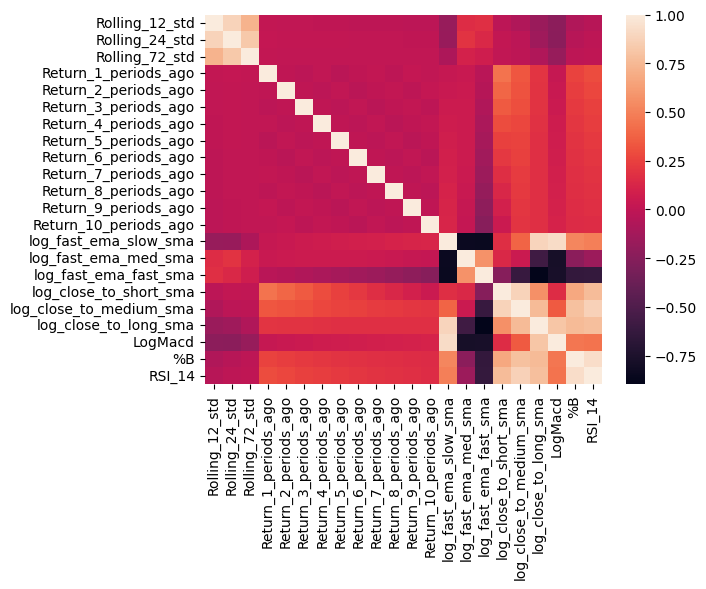

In [203]:
import seaborn as sns
sns.heatmap(feature_correlation)

In [207]:
features.tail(10)

,Rolling_12_std,Rolling_24_std,Rolling_72_std,Return_1_periods_ago,Return_2_periods_ago,Return_3_periods_ago,Return_4_periods_ago,Return_5_periods_ago,Return_6_periods_ago,Return_7_periods_ago,...,Return_10_periods_ago,log_fast_ema_slow_sma,log_fast_ema_med_sma,log_fast_ema_fast_sma,log_close_to_short_sma,log_close_to_medium_sma,log_close_to_long_sma,LogMacd,%B,RSI_14
21947,0.005591,0.004148,0.003525,-0.004761,-0.003866,-0.000858,0.012923,0.004447,0.005342,0.001528,...,-0.001992,-0.002527,0.003788,-0.001892,-0.002257,0.003424,-0.002892,0.000258,0.483687,49.299877
21948,0.006716,0.004851,0.003804,-0.008448,-0.004761,-0.003866,-0.000858,0.012923,0.004447,0.005342,...,0.004271,-0.003108,0.003125,-0.002294,-0.014177,-0.008758,-0.014991,-0.000122,0.131013,38.792928
21949,0.007056,0.005106,0.003911,-0.012146,-0.008448,-0.004761,-0.003866,-0.000858,0.012923,0.004447,...,0.000156,-0.003975,0.002393,-0.002611,-0.021273,-0.016269,-0.022637,-0.000703,-0.060090,33.837040
21950,0.007522,0.005469,0.004070,-0.007846,-0.012146,-0.008448,-0.004761,-0.003866,-0.000858,0.012923,...,0.001528,-0.004402,0.001912,-0.002763,-0.011600,-0.006924,-0.013239,-0.000962,0.215650,43.089584
21951,0.007560,0.005486,0.004086,0.009345,-0.007846,-0.012146,-0.008448,-0.004761,-0.003866,-0.000858,...,0.005342,-0.004929,0.001322,-0.002790,-0.014057,-0.009945,-0.016196,-0.001291,0.144416,41.026494
21952,0.007530,0.005463,0.004086,-0.003092,0.009345,-0.007846,-0.012146,-0.008448,-0.004761,-0.003866,...,0.004447,-0.005459,0.000855,-0.002632,-0.014042,-0.010555,-0.016869,-0.001616,0.137715,40.476181
21953,0.007288,0.005392,0.004086,-0.000818,-0.003092,0.009345,-0.007846,-0.012146,-0.008448,-0.004761,...,0.012923,-0.005943,0.000590,-0.001992,-0.012707,-0.010125,-0.016657,-0.001911,0.153491,40.541220
21954,0.007128,0.005401,0.004056,0.000062,-0.000818,-0.003092,0.009345,-0.007846,-0.012146,-0.008448,...,-0.000858,-0.006267,0.000327,-0.000986,-0.009647,-0.008334,-0.014928,-0.002133,0.206943,42.233328
21955,0.005518,0.005404,0.003799,0.001543,0.000062,-0.000818,-0.003092,0.009345,-0.007846,-0.012146,...,-0.003866,-0.006443,0.000064,0.001168,-0.007968,-0.009072,-0.015579,-0.002365,0.190099,41.397024
21956,0.005536,0.005401,0.003795,-0.001015,0.001543,0.000062,-0.000818,-0.003092,0.009345,-0.007846,...,-0.004761,-0.006630,-0.000154,0.003294,-0.005647,-0.009096,-0.015571,-0.002585,0.193382,41.108671
